# install the needed libraries

In [86]:
!pip -q install pyddm

In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm
import pyddm.plot
from scipy.stats import ttest_rel
from tqdm import tqdm

# load data

In [88]:
df_raw = pd.read_csv("dataset-9 - Copy.tsv", sep="\t")
df_raw.head()

,subjects,S,age,R,rt
0,1,right,age17,right,0.422023
1,1,left,age17,left,0.590425
2,1,left,age17,right,0.430260
3,1,right,age17,left,0.478868
4,1,left,age17,right,0.366551


# plot the reaction times

whole dataset

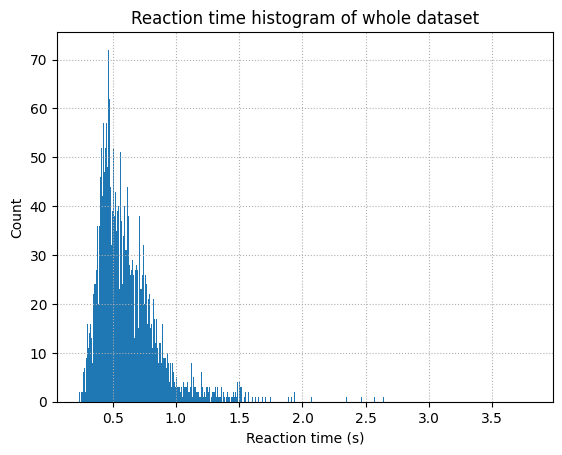

In [89]:
plt.grid(True, linestyle=":")
plt.hist(df_raw["rt"], bins=1000)
plt.title("Reaction time histogram of whole dataset")
plt.xlabel("Reaction time (s)")
plt.ylabel("Count")
plt.show()

dataset without outliers

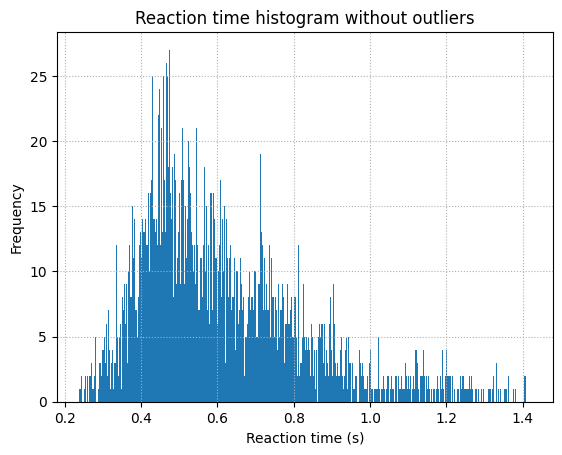

In [406]:
plt.grid(True, linestyle=":")
# filter out the outliers based on zscore
mean = df_raw["rt"].mean()
std_dev = df_raw["rt"].std()
df_raw["zscore"] = (df_raw["rt"] - mean) / std_dev
df = df_raw[df_raw["zscore"].abs() <= 3].copy()
plt.hist(df["rt"], bins=1000)
plt.title("Reaction time histogram without outliers")
plt.xlabel("Reaction time (s)")
plt.ylabel("Frequency")
plt.show()

In [288]:
# create a new column that stores if the response was correct
df["correct"] = df["S"] == df["R"]
# split data into the two age groups
df_17 = df[df["age"] == "age17"]
df_25 = df[df["age"] == "age25"]
df.head()

,subjects,S,age,R,rt,zscore,correct
0,1,right,age17,right,0.422023,-0.779518,True
1,1,left,age17,left,0.590425,-0.143410,True
2,1,left,age17,right,0.430260,-0.748407,False
3,1,right,age17,left,0.478868,-0.564796,False
4,1,left,age17,right,0.366551,-0.989056,False


# histogram and density plot of the data for ages 17 an 25

histogram

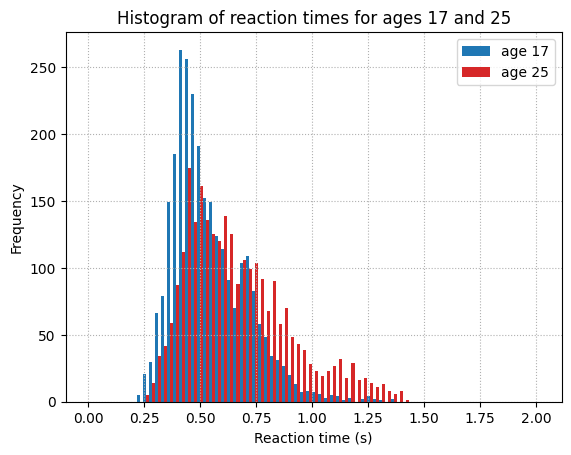

In [289]:
plt.grid(True, linestyle=":")
# define how the bins will look
bins = np.linspace(0, 2, 75)
bar_width = (bins[1] - bins[0]) / 2

# Plot the histograms
plt.hist(
    df_17["rt"], bins=bins, label="age 17", width=bar_width,
    color="tab:blue"
    )
plt.hist(
    df_25["rt"], bins=bins + bar_width, label="age 25", width=bar_width,
    color="tab:red"
    )

plt.legend()
plt.title("Histogram of reaction times for ages 17 and 25")
plt.xlabel("Reaction time (s)")
plt.ylabel("Frequency")
plt.show()

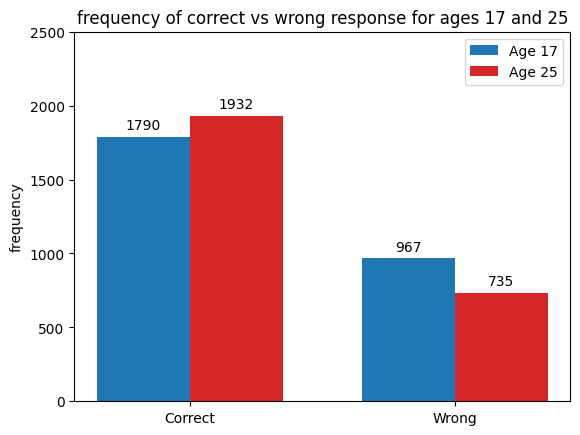

In [290]:
import matplotlib.pyplot as plt
import numpy as np

bars = ("Correct", "Wrong")
ages = {
    'Age 17': [df_17["correct"].sum(), len(df_17[df_17["correct"] == False])],
    'Age 25': [df_25["correct"].sum(), len(df_25[df_25["correct"] == False])]
}

x = np.arange(len(bars))
width = 0.35
multiplier = 0

for age, frequency in ages.items():
    color = "tab:blue" if age == "Age 17" else "tab:red"
    offset = width * multiplier
    rects = plt.bar(x + offset, frequency, width, label=age, color=color)
    plt.bar_label(rects, padding=3)
    multiplier += 1

plt.ylabel('frequency')
plt.title('frequency of correct vs wrong response for ages 17 and 25')
plt.xticks(x + width/2, bars)
plt.legend()
plt.ylim(0, 2500)

plt.show()

density plot

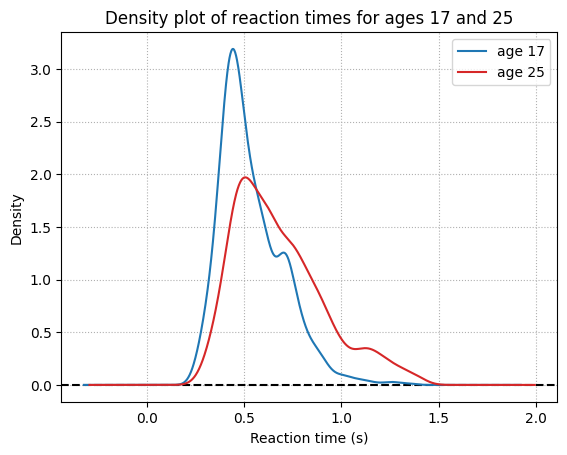

In [291]:
plt.axhline(0, color="black", linestyle="--")
df_17["rt"].plot.density(color="tab:blue", label="age 17")
df_25["rt"].plot.density(color="tab:red", label="age 25")
plt.grid(True, linestyle=":")
plt.legend()
plt.title("Density plot of reaction times for ages 17 and 25")
plt.xlabel("Reaction time (s)")
plt.show()

# histogram plotting means of reaction times and correct responses

reaction time

pvalue: 2.1455609560171483e-05


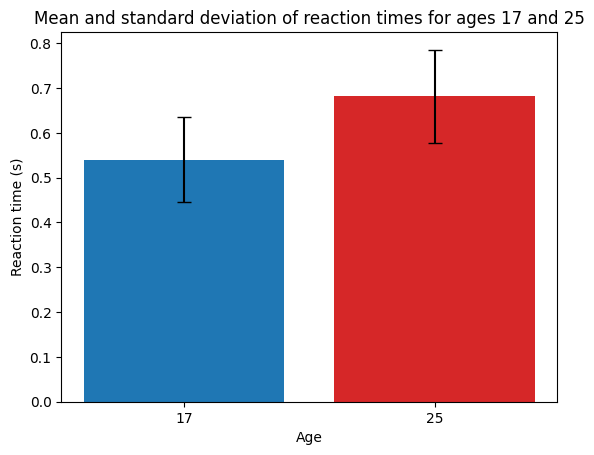

In [407]:
cond1 = [df_17[df_17["subjects"] == subject]["rt"].mean() for subject in df_17["subjects"].unique()]
cond2 = [df_25[df_25["subjects"] == subject]["rt"].mean() for subject in df_25["subjects"].unique()]

print(f"pvalue: {ttest_rel(cond1, cond2).pvalue}")

rt_means = [np.mean(cond1), np.mean(cond2)]
rt_stds = [np.std(cond1), np.std(cond2)]

plt.bar(["17", "25"], rt_means, yerr=rt_stds, color=["tab:blue", "tab:red"], capsize=5)
plt.title("Mean and standard deviation of reaction times for ages 17 and 25")
plt.xlabel("Age")
plt.ylabel("Reaction time (s)")
plt.show()

correct response probability

pvalue: 4.556756617083944e-05


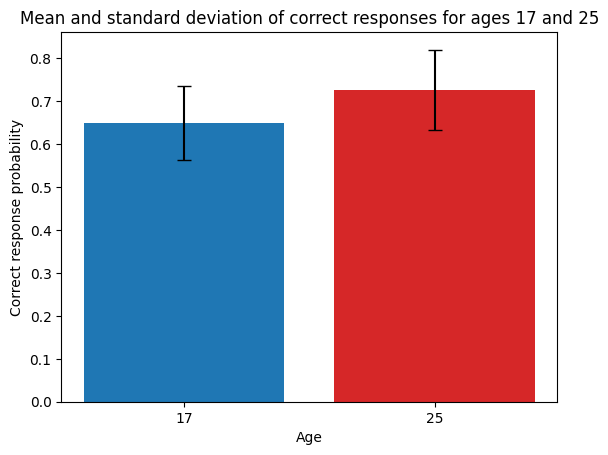

In [408]:
cond1 = [df_17[df_17["subjects"] == subject]["correct"].mean() for subject in df_17["subjects"].unique()]
cond2 = [df_25[df_25["subjects"] == subject]["correct"].mean() for subject in df_25["subjects"].unique()]

print(f"pvalue: {ttest_rel(cond1, cond2).pvalue}")

correct_means = [np.mean(cond1), np.mean(cond2)]
correct_stds = [np.std(cond1), np.std(cond2)]

plt.bar(["17", "25"], correct_means, yerr=correct_stds, color=["tab:blue", "tab:red"], capsize=5)
plt.title("Mean and standard deviation of correct responses for ages 17 and 25")
plt.xlabel("Age")
plt.ylabel("Correct response probability")
plt.show()

# fit model on ages 17 and 25

class to determine the initial condition

In [295]:
class ICPointSideBias(pyddm.InitialCondition):
    name = "A starting point with a left or right bias."
    required_parameters = ["x0"]
    required_conditions = ["S"]
    def get_IC(self, x, dx, conditions):
        start = np.round(self.x0/dx)
        # Positive bias for right, negative for left
        if conditions["S"] == "left":
            start = -start
        shift_i = int(start + (len(x)-1)/2)
        assert shift_i >= 0 and shift_i < len(x), "Invalid initial conditions"
        pdf = np.zeros(len(x))
        pdf[shift_i] = 1.
        return pdf

plot the fitted model for ages 17 and 25

Info: Params [0.57747402 0.57646844 0.005063   0.23755285] gave 784.7463158422734
Info:pyddm:Params [0.57747402 0.57646844 0.005063   0.23755285] gave 784.7463158422734
Info: Params [ 0.75942896  0.68076654 -0.00860349  0.2749615 ] gave 1423.4143903738316
Info:pyddm:Params [ 0.75942896  0.68076654 -0.00860349  0.2749615 ] gave 1423.4143903738316


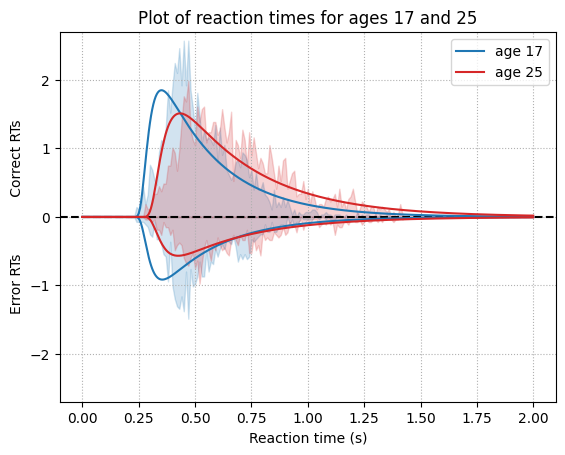

In [303]:
# age 17
m = pyddm.Model(
    drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
    bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.1, maxval=2)),
    IC=ICPointSideBias(x0=pyddm.Fittable(minval=-.1, maxval=.1)),
    overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
    )

sample = pyddm.Sample.from_pandas_dataframe(df_17, rt_column_name="rt", choice_column_name="correct")
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)
plt.grid(True, linestyle=":")
plt.axhline(0, color="black", linestyle="--")
plt.plot(m.t_domain(), m.solve(conditions={"S": "right"}).pdf("correct"), color="tab:blue", label="age 17")
plt.plot(m.t_domain(), -1 * m.solve(conditions={"S": "right"}).pdf("error"), color="tab:blue")
plt.fill_between(
    sample.t_domain(), sample.pdf("correct"), color="tab:blue",
    alpha=0.2
    )
plt.fill_between(
    sample.t_domain(), -1 * sample.pdf("error"), color="tab:blue",
    alpha=0.2
    )

# age 25
m = pyddm.Model(
    drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
    bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.1, maxval=2)),
    IC=ICPointSideBias(x0=pyddm.Fittable(minval=-.1, maxval=.1)),
    overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
    )

sample = pyddm.Sample.from_pandas_dataframe(df_25, rt_column_name="rt", choice_column_name="correct")
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

plt.plot(m.t_domain(), m.solve(conditions={"S": "right"}).pdf("correct"), color="tab:red", label="age 25")
plt.plot(m.t_domain(), -1 * m.solve(conditions={"S": "right"}).pdf("error"), color="tab:red")
plt.fill_between(
    sample.t_domain(), sample.pdf("correct"), color="tab:red",
    alpha=0.2
    )
plt.fill_between(
    sample.t_domain(), -1 * sample.pdf("error"), color="tab:red",
    alpha=0.2
    )

# plot
plt.ylim(-2.7, 2.7)
plt.legend()
plt.title("Plot of reaction times for ages 17 and 25")
plt.xlabel("Reaction time (s)")
plt.ylabel("Error RTs             Correct RTs")
plt.show()

function to fit a model given the subject and age

In [410]:
def fit_model(subject: int, age: str) -> pyddm.model.Model:
  m = pyddm.Model(
      drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
      bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.1, maxval=2)),
      IC=ICPointSideBias(x0=pyddm.Fittable(minval=-.1, maxval=.1)),
      overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
      )
  sample = pyddm.Sample.from_pandas_dataframe(df[(df["subjects"] == subject) & (df["age"] == age)], rt_column_name="rt", choice_column_name="correct")
  pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

  return m

make dataframe of parameter values per condition per subject

In [307]:
# dataframe that will hold the parameter values per conditino par subject
df_parameter_values = pd.DataFrame(columns=["subjects", "age", "drift", "B", "x0", "nondectime"])

# go over every subject
for subject in tqdm(df["subjects"].unique()):
  # go over every age
  for age in tqdm(df["age"].unique()):
    # fit a model
    m = fit_model(subject, age)
    # get the parameter names and values from the model and add them to the dataframe
    parameter_values = [subject, age] + [float(parameter) for parameter in m.get_model_parameters()]
    parameter_names = ["subjects", "age"] + m.get_model_parameter_names()
    df_parameter_values.loc[len(df_parameter_values)] = dict(zip(parameter_names, parameter_values))

df_parameter_values

  0%|          | 0/2 [00:00<?, ?it/s]Info: Params [ 0.65205575  0.50636588 -0.00966116  0.31527886] gave 39.47859390173536
Info:pyddm:Params [ 0.65205575  0.50636588 -0.00966116  0.31527886] gave 39.47859390173536

 50%|█████     | 1/2 [00:09<00:09,  9.65s/it]Info: Params [ 0.86953649  0.72546643 -0.02617221  0.33284845] gave 121.895871268897
Info:pyddm:Params [ 0.86953649  0.72546643 -0.02617221  0.33284845] gave 121.895871268897

  0%|          | 0/2 [00:00<?, ?it/s]Info: Params [ 0.5284588   0.40286906 -0.00850661  0.3292711 ] gave -44.13499026876525
Info:pyddm:Params [ 0.5284588   0.40286906 -0.00850661  0.3292711 ] gave -44.13499026876525

 50%|█████     | 1/2 [00:10<00:10, 10.99s/it]Info: Params [0.73824931 0.59582586 0.00150732 0.33676755] gave 83.7279327318381
Info:pyddm:Params [0.73824931 0.59582586 0.00150732 0.33676755] gave 83.7279327318381

  0%|          | 0/2 [00:00<?, ?it/s]Info: Params [0.98940969 0.37928665 0.01416053 0.42759179] gave -102.04364485011236
Info:pyddm:Pa

,subjects,age,drift,B,x0,nondectime
0,1,age17,0.652056,0.506366,-0.009661,0.315279
1,1,age25,0.869536,0.725466,-0.026172,0.332848
2,2,age17,0.528459,0.402869,-0.008507,0.329271
3,2,age25,0.738249,0.595826,0.001507,0.336768
4,3,age17,0.989410,0.379287,0.014161,0.427592
5,3,age25,1.025424,0.548006,0.004346,0.434944
6,4,age17,0.942176,0.456285,0.005280,0.498802
7,4,age25,1.056881,0.560092,-0.003630,0.497898
8,5,age17,0.775564,0.353292,-0.003102,0.382140
9,5,age25,0.694367,0.491991,0.027164,0.381234


# paired t-test

function that performs a t-test on the two conditions given a parameter

In [411]:
def perform_t_test(parameter: str):
  # get the values for the two conditions
  cond1 = df_parameter_values[df_parameter_values["age"] == "age17"][parameter]
  cond2 = df_parameter_values[df_parameter_values["age"] == "age25"][parameter]

  # calculate and print the t-value
  print(f"pvalue: {ttest_rel(cond1, cond2).pvalue}")

  means = [cond1.mean(), cond2.mean()]
  stds = [cond1.std(), cond2.std()]

  # plot the mean and standard deviation
  plt.bar(["17", "25"], means, yerr=stds, color=["tab:blue", "tab:red"], capsize=5)
  plt.title(f"Mean and standard deviation of {parameter} for ages 17 and 25")
  plt.xlabel("Age")
  plt.ylabel(parameter)
  plt.show()

drift:
pvalue: 0.038033552365845526


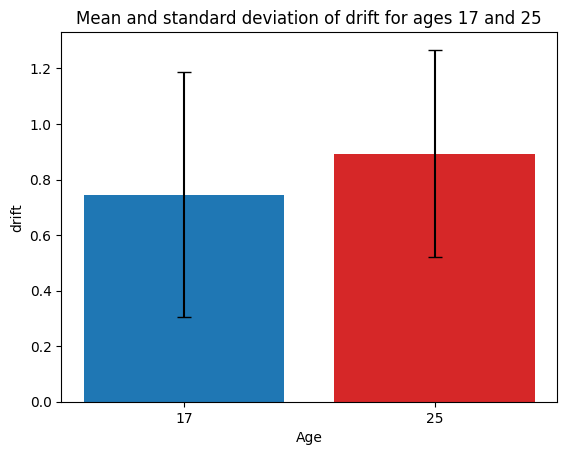


B:
pvalue: 2.552403936486483e-05


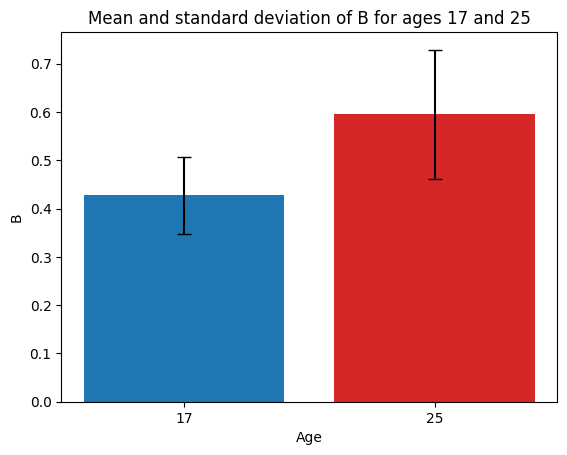


x0:
pvalue: 0.559185649424343


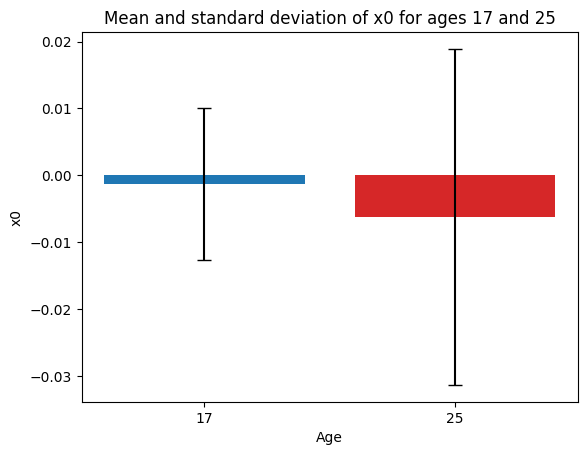

In [412]:
# perform the t-test on every parameter
for i in ["drift", "B", "x0"]:
  print(i + ":")
  perform_t_test(i)
  print()